In [1]:
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd() ,"..")))

In [3]:
# Import libraries
import src.data.sql_functions as sql
import src.data.data_transformation as cln
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings                        

In [4]:
# Global variables
warnings.filterwarnings("ignore")
DB_SERVER   = "tcp:AUCLD04018656,1433"
DB_NAME     = "team_five_aiml_group"
LIST_CONVERT_FLOAT = [
'bitcoin_transaction'                       
,'size_btc'                                  
,'sentbyaddress_btc'                         
,'bitcoin_difficulty'                        
,'bitcoin_hashrate'                          
,'bitcoin_mining_profitability'              
,'sentinusd_btc'                             
,'bitcoin_transactionfees'                   
,'bitcoin_median_transaction_fee'            
,'bitcoin_confirmationtime'                  
,'transactionvalue_btc'                      
,'mediantransactionvalue_btc'                
,'tweets_btc'                                
,'google_trends_btc'                         
,'activeaddresses_btc'                       
,'top100cap_btc'                             
,'fee_to_reward_btc'] 

In [5]:
# Get market/supp data from database
conn = sql.SqlDb(DB_SERVER, DB_NAME)
get_query = "SELECT * FROM [{db}].[dbo].BTC_AUD_{dt} A LEFT JOIN [{db}].[dbo].BTC_SUPP_DATA_{dt} B ON A.mkt_Date = B.supp_date".format(db=DB_NAME, dt="20130101_20230127")
df_btc_input = conn.query(get_query, True)
conn.__del__

<bound method SqlDb.__del__ of <src.data.sql_functions.SqlDb object at 0x0000020DE8E077F0>>

In [6]:
# Create next day closing price variable
df_btc_input['t_plus_1_Close'] = df_btc_input['mkt_Close'].shift(-1)
for c in LIST_CONVERT_FLOAT:
     df_btc_input[c] = df_btc_input[c].astype(float) 
clean_df_btc_input = cln.clean_df(df_btc_input)
clean_df_btc_input.head()

,mkt_Date,mkt_Open,mkt_High,mkt_Low,mkt_Close,mkt_Adj_Close,mkt_Volume,supp_date,bitcoin_transaction,size_btc,...,bitcoin_median_transaction_fee,bitcoin_confirmationtime,transactionvalue_btc,mediantransactionvalue_btc,tweets_btc,google_trends_btc,activeaddresses_btc,top100cap_btc,fee_to_reward_btc,t_plus_1_Close
0,2014-09-17,513.122620,516.007935,504.935272,510.645386,510.645386,23511389,2014-09-17,80119.0,240563.0,...,0.0456,7.742,2636.0,110.753,27946.0,7.619,170439.0,19.806,0.264,472.650330
1,2014-09-18,510.116119,510.002228,459.924286,472.650330,472.650330,38400000,2014-09-18,77185.0,236621.0,...,0.0439,8.045,3951.0,131.235,21135.0,7.619,171901.0,19.848,0.276,442.249359
2,2014-09-19,472.275055,477.761017,428.161682,442.249359,442.249359,42477540,2014-09-19,69266.0,221271.0,...,0.0406,8.421,4006.0,130.667,20775.0,9.675,150729.0,19.822,0.248,458.053101
3,2014-09-20,442.111572,474.174957,436.745819,458.053101,458.053101,41294500,2014-09-20,63306.0,208320.0,...,0.0410,8.182,4860.0,94.343,17607.0,7.377,149520.0,19.925,0.233,446.308197
4,2014-09-21,457.135651,461.998413,440.440247,446.308197,446.308197,29744964,2014-09-21,59636.0,217914.0,...,0.0401,8.780,5157.0,80.706,17026.0,7.498,171703.0,19.952,0.228,453.077972


In [7]:
# Create plotting functions
def plot_data(df, feature, exclude_feature='t_plus_1_Close'):
    # Line chart
    rand_colour = (rand.random(), rand.random(), rand.random())
    df.plot(x='mkt_Date', y=feature, figsize=(25,5), grid=True, color=rand_colour)
    plt.title(f'Date VS {feature.replace("_"," ")}')
    plt.ylabel(feature)
    plt.show()

    # Kernel density estimation
    df.plot(kind='kde', y=feature, figsize=(25,5), grid=True, color=rand_colour)
    plt.title(f'KDE - {feature.replace("_"," ")}')
    plt.show()

    # Correlations
    corr = df.corr().loc[[feature],:].sort_values(by=feature,axis=1).drop(columns=[feature,exclude_feature])
    plt.figure(figsize = (25,5))
    sns.heatmap(corr, cmap='tab10', square=True, annot=True, cbar=False, annot_kws={"fontsize":16}, linewidths=1, linecolor='black', )
    plt.title(f'Correlations with other features')
    plt.show()

def plot_scatter(df,scatter_list,scatter_with):
    fig,axs = plt.subplots(1,len(scatter_list),sharey=False,figsize=(7*len(scatter_list),7))
    colors = plt.rcParams["axes.prop_cycle"]()
    for i,feat in enumerate(scatter_list):
        x = sorted(list(df[scatter_with]))
        y = sorted(list(df[feat]))

        axs[i].scatter(x,y,marker=".",color=next(colors)["color"],label=feat)

        line = mlines.Line2D([0, 1], [0, 1], color='black',linestyle=':',label='Normal Line')
        transform = axs[i].transAxes
        line.set_transform(transform)
        axs[i].add_line(line)
        axs[i].set_ylabel(feat)
        axs[i].grid()
        axs[i].set_xlabel(scatter_with)
        axs[i].legend()
    plt.show()


## Next day closing price

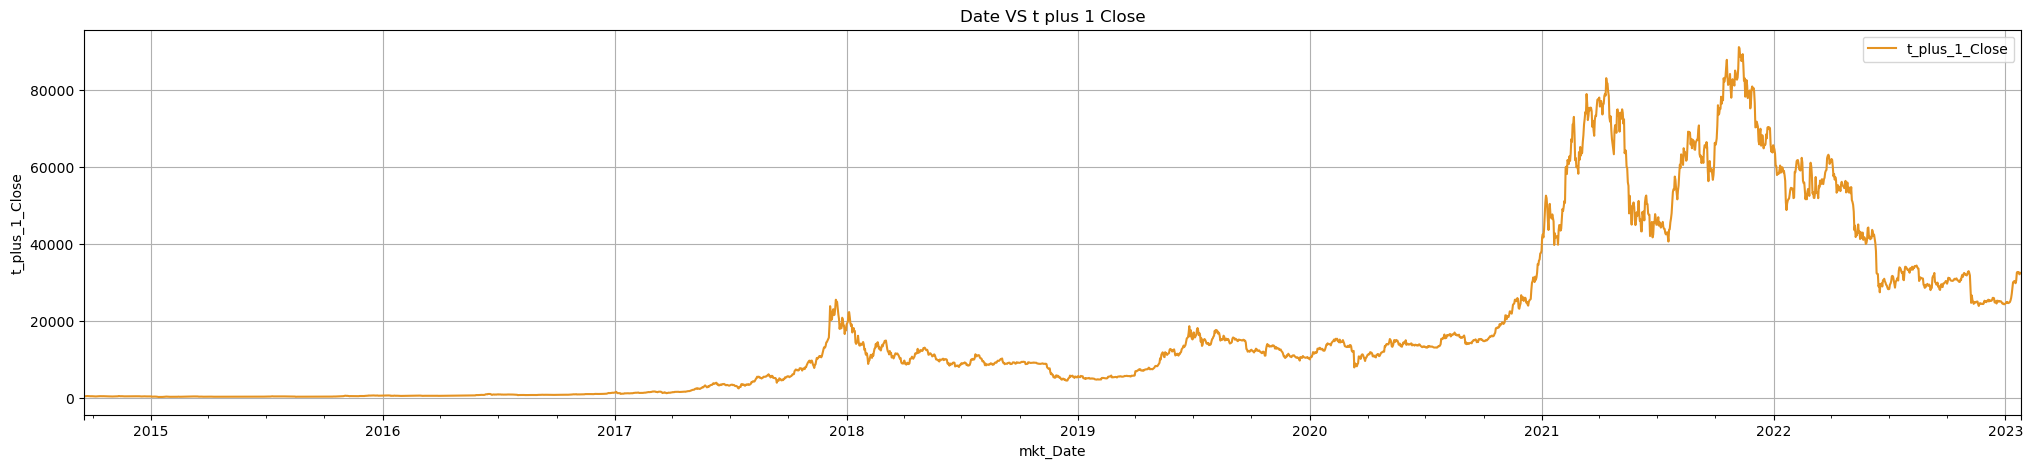

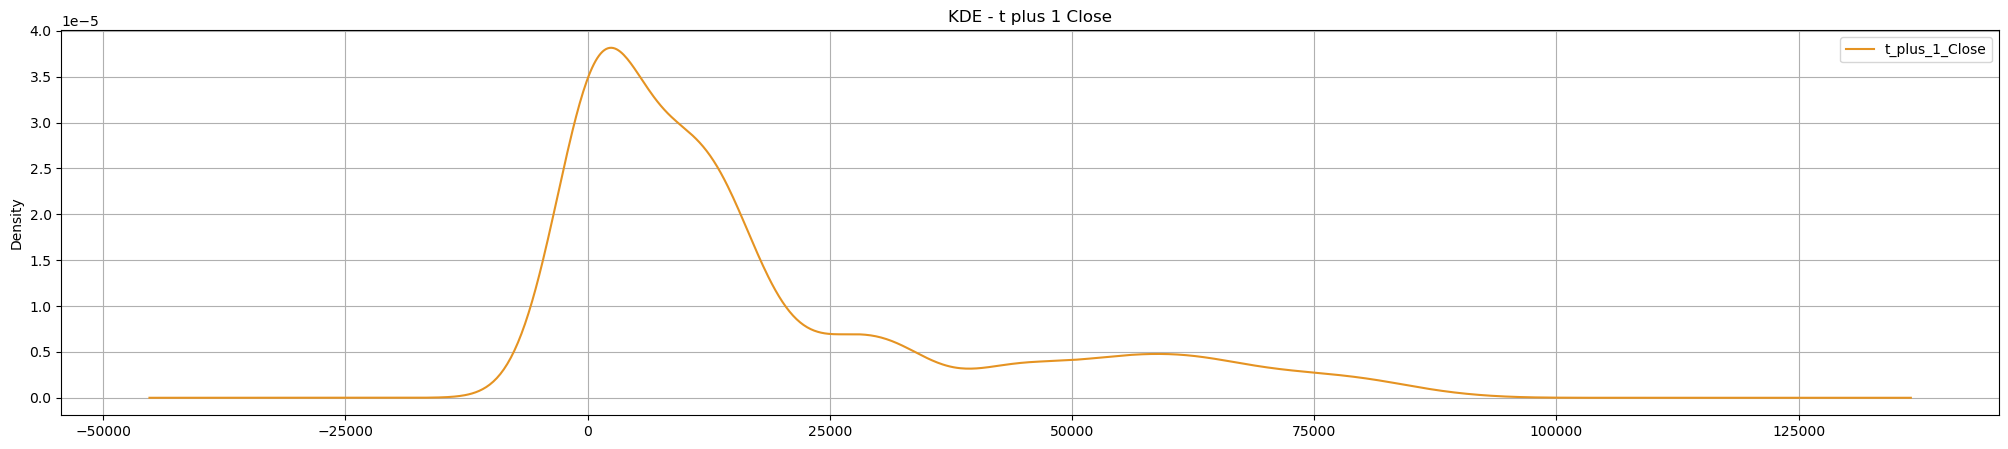

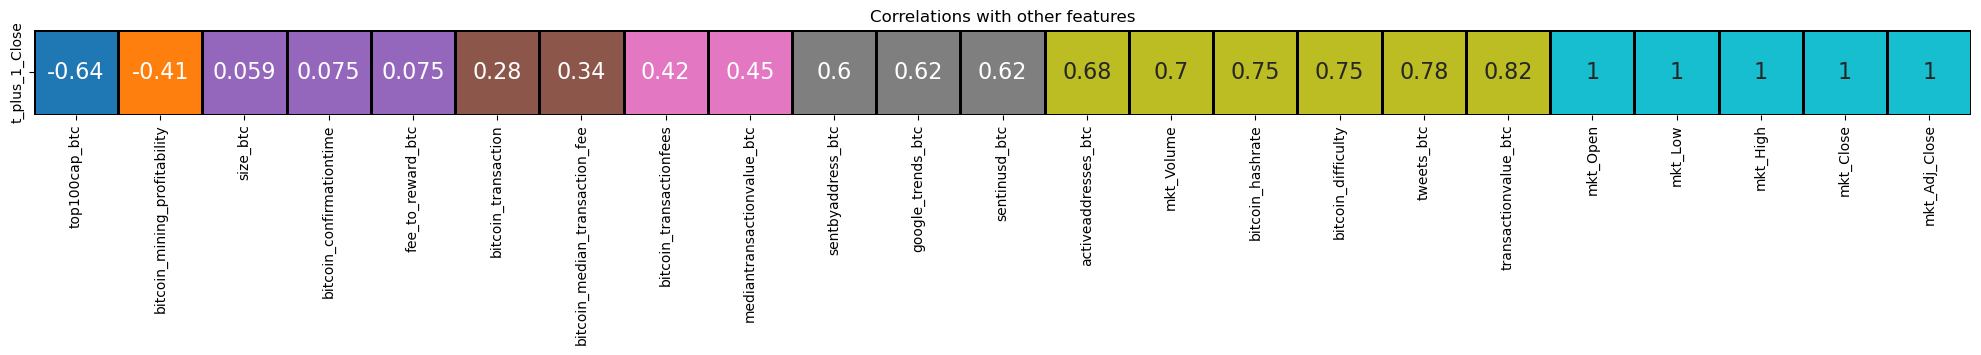

In [8]:
plot_data(df_btc_input, feature='t_plus_1_Close')

### Observations

<p>A non stationary process, will need to predict returns.</p>
<p>Reasonable correlation with google searches/tweets and close pricing - would be interesting to see +/- news impacts.</p>
<p>Interestingly, there is a negative correlation between % of 100 richest accounts and closing price - is this simply bitcoin becoming more mainstream? </p>

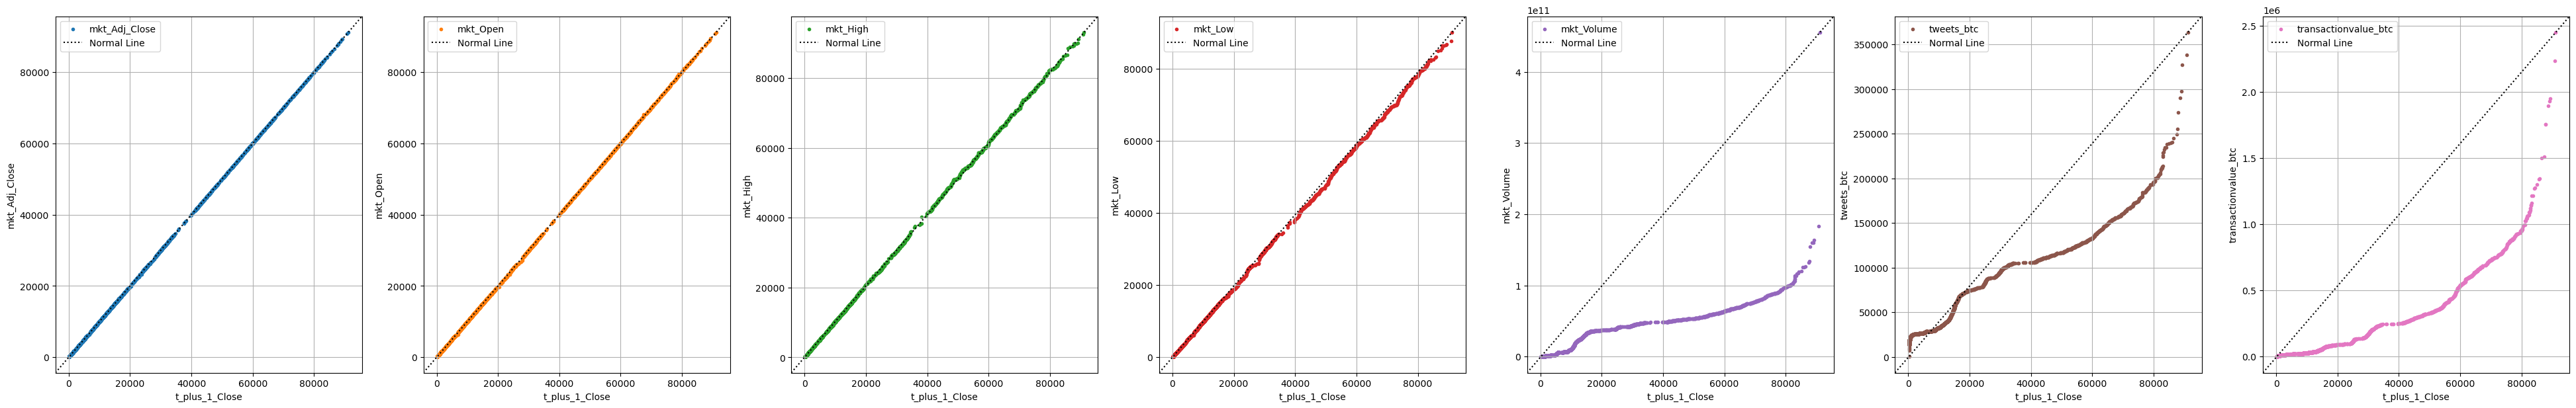

In [9]:
scatter_list = ['mkt_Adj_Close','mkt_Open','mkt_High','mkt_Low','mkt_Volume', 'tweets_btc', 'transactionvalue_btc']
plot_scatter(df_btc_input,scatter_list,'t_plus_1_Close')

				

## Number of Daily Transactions

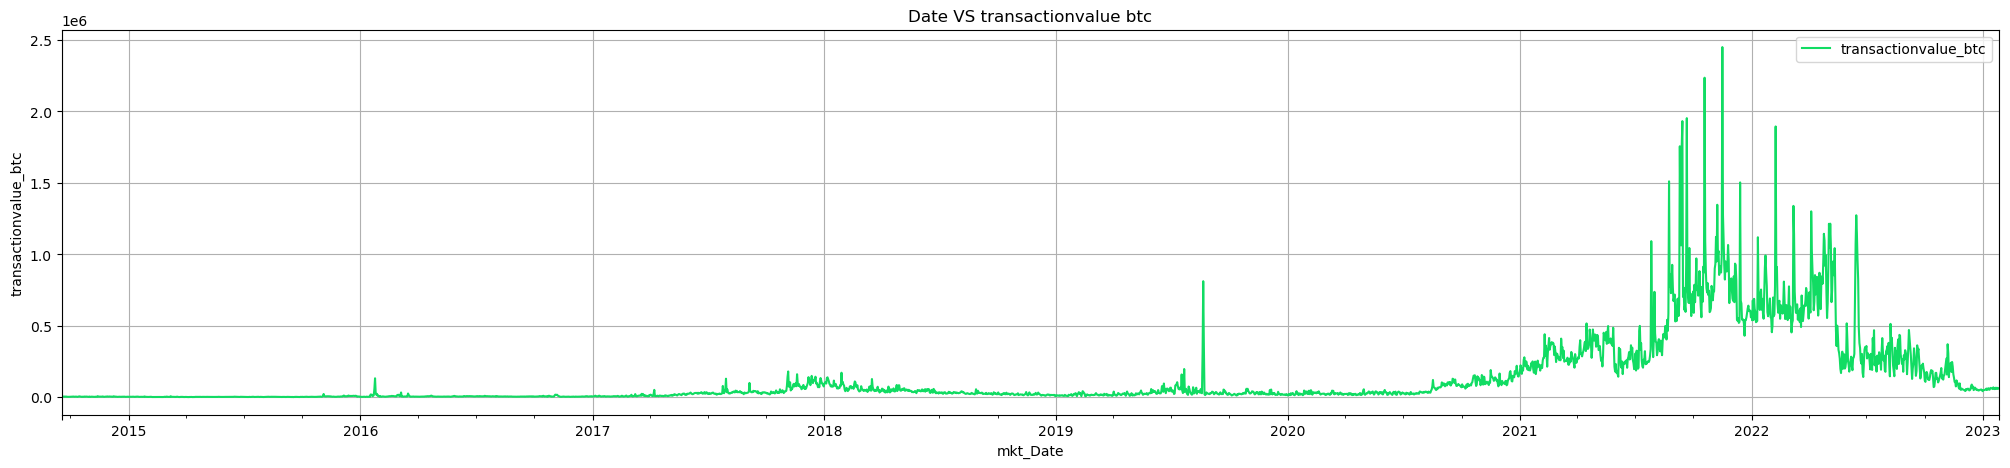

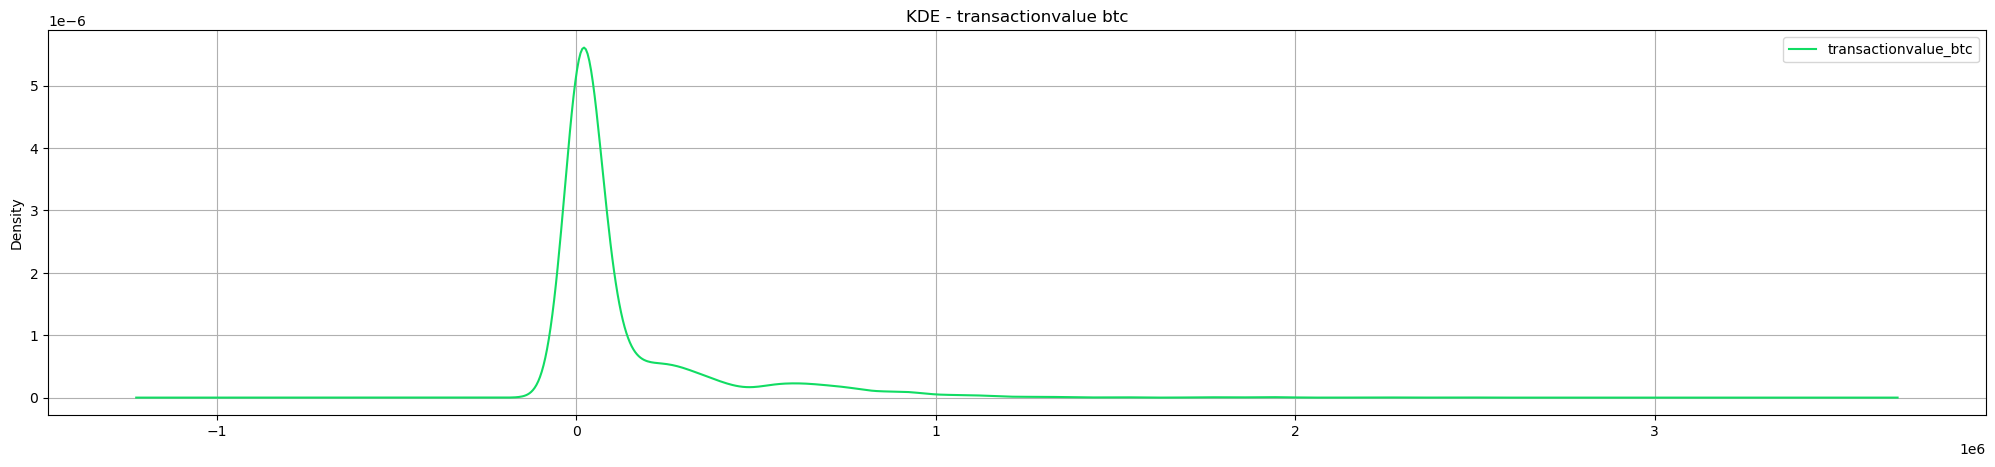

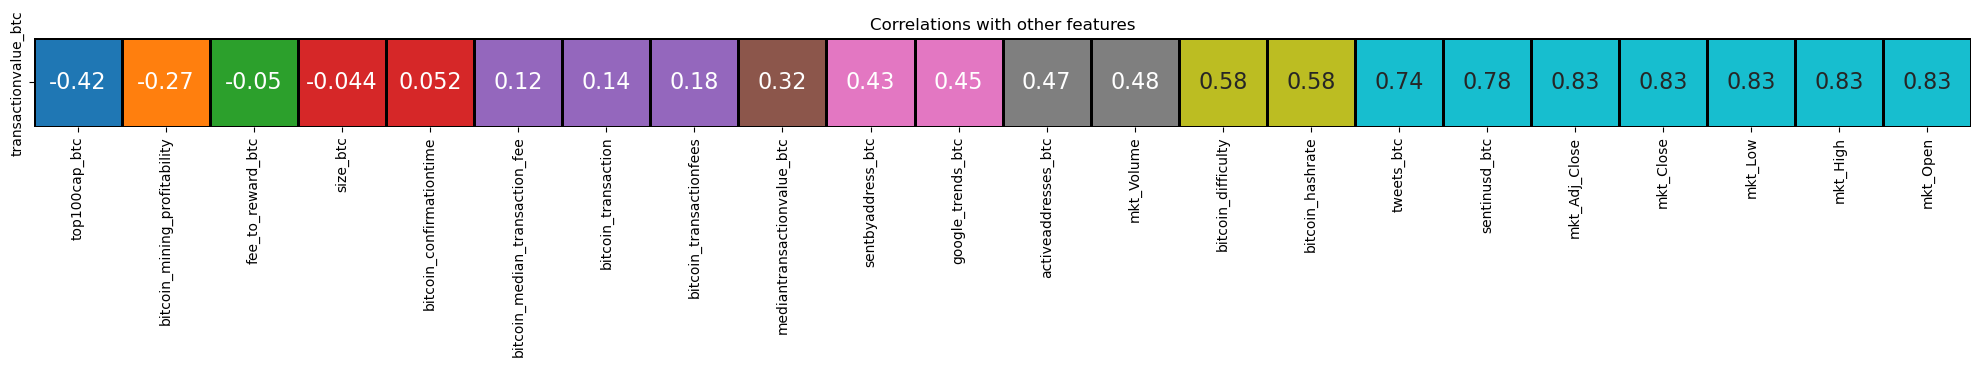

In [23]:
plot_data(df_btc_input, feature='transactionvalue_btc')